In [1]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
from data_handling import *
from tqdm import tqdm
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from settings.default import CURRENCIES
import statsmodels.api as sm
from scipy.stats import norm
import scipy.stats as stats

In [2]:
## download fomc event dates
fomc_calendar = pd.read_parquet('data/FOMC/fomc_calendar.parquet').set_index('datetime')
fomc_calendar

,unscheduled
datetime,
1960-12-13,False
1961-01-10,False
1961-01-24,False
1961-02-07,False
1961-03-07,False
...,...
2023-06-13,False
2023-07-25,False
2023-09-19,False


visualizing how many FOMC event we have in our dataset

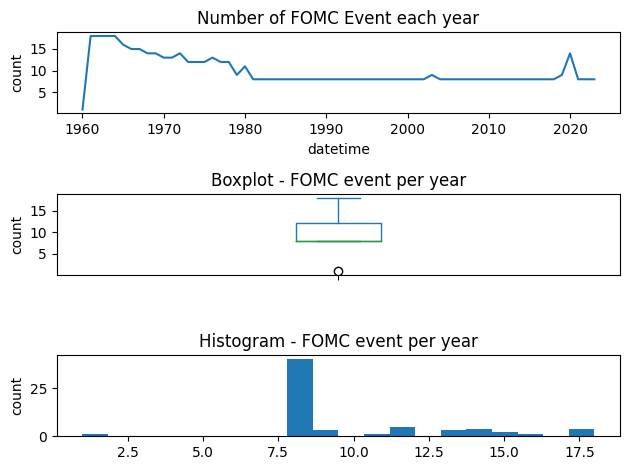

In [3]:
count_year =fomc_calendar.groupby(fomc_calendar.index.year).size()
fig,axes = plt.subplots(nrows=3,ncols =1)
count_year.plot(ax = axes[0])
axes[0].set_title('Number of FOMC Event each year')
axes[0].set_ylabel('count')

count_year.plot(kind = 'box',ax=axes[1])
axes[1].set_title('Boxplot - FOMC event per year')
axes[1].set_ylabel('count')

count_year.plot(kind = 'hist',ax=axes[2],bins = 20)
axes[2].set_title('Histogram - FOMC event per year')
axes[2].set_ylabel('count')
fig.tight_layout()
fig.savefig("plots/FOMC_count.png")

## Regressors - Macroeconomic indicators


here is a quick view on the macroecnomic regressors we use for USD/JPY model. This will encompass several macroeconomic time series concerning the american economy, as well as specific time series for Japan's economy

In [4]:
indicator,Y = reindex_X("JPY",max_nan_pct =20)
indicator

,T10Y2Y,BAA10Y,T10YFF,TB3SMFFM,BAAFF,MORTGAGE30US,DFF,UNRATE,CPIAUCSL,WM2NS,...,EXPINF10YR,DPCCRV1Q225SBEA,PCETRIM12M159SFRBDAL,EXPINF2YR,EXPINF1YR,STICKCPIM157SFRBATL,EXPINF30YR,JPNRGDPEXP,NIKKEI225,IRLTLT01JPM156N
datetime,,,,,,,,,,,,,,,,,,,,,
1997-12-31,0.09,1.53,-0.09,-0.34,1.44,6.99,5.84,4.7,161.80,4055.4,...,2.993990,1.3,1.73,2.999453,2.935461,0.248350,2.976678,477171.5,15258.74,1.939
1998-01-01,0.09,1.53,-0.09,-0.52,1.44,6.99,5.84,4.6,162.00,4055.4,...,2.952356,1.2,1.66,2.878344,2.757011,0.243950,2.957381,471353.6,15258.74,1.948
1998-01-02,0.08,1.54,-0.39,-0.52,1.15,7.03,6.06,4.6,162.00,4055.4,...,2.952356,1.2,1.66,2.878344,2.757011,0.243950,2.957381,471353.6,15258.74,1.948
1998-01-03,0.08,1.54,-0.39,-0.52,1.15,7.03,6.06,4.6,162.00,4055.4,...,2.952356,1.2,1.66,2.878344,2.757011,0.243950,2.957381,471353.6,15258.74,1.948
1998-01-04,0.08,1.54,-0.39,-0.52,1.15,7.03,6.06,4.6,162.00,4055.4,...,2.952356,1.2,1.66,2.878344,2.757011,0.243950,2.957381,471353.6,15258.74,1.948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-24,-0.16,1.61,-1.15,-0.09,0.46,6.60,5.33,3.7,308.85,20959.2,...,2.156756,2.0,3.29,2.333665,2.431933,0.372295,2.334162,558240.3,36226.48,0.585
2024-01-25,-0.14,1.60,-1.19,-0.09,0.41,6.69,5.33,3.7,308.85,20959.2,...,2.156756,2.0,3.29,2.333665,2.431933,0.372295,2.334162,558240.3,36236.47,0.585
2024-01-26,-0.19,1.58,-1.18,-0.09,0.40,6.69,5.33,3.7,308.85,20959.2,...,2.156756,2.0,3.29,2.333665,2.431933,0.372295,2.334162,558240.3,35751.07,0.585


visualizing some indicators before and after treating non stationnarity

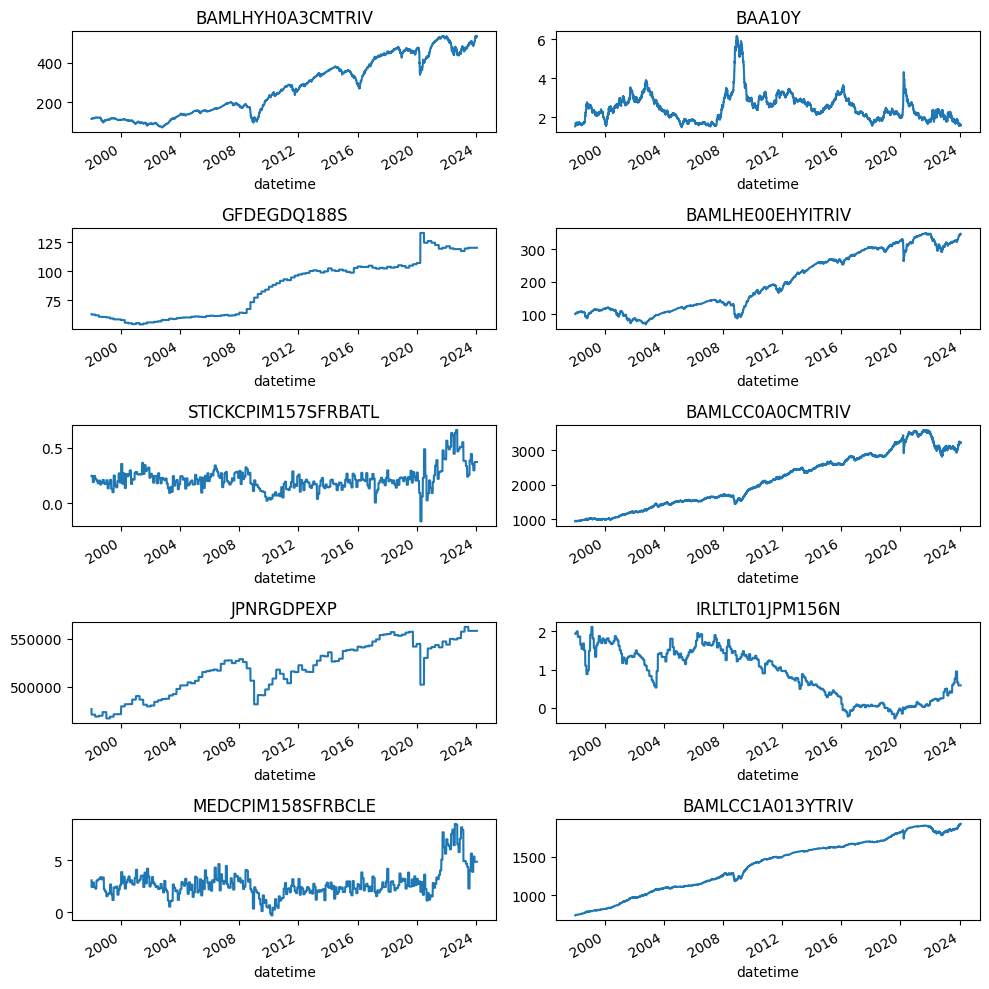

In [5]:
random_indicators = random.sample(indicator.columns.tolist(),10)
fig,axes = plt.subplots(nrows = 5, ncols = 2,figsize = (10,10))
rows = 5
cols = 2
for i,ax in enumerate(axes.flatten()):
    ts = random_indicators[i]
    indicator[ts].dropna().plot(ax = ax)
    ax.set_title(ts)

fig.tight_layout()
fig.savefig('plots/macro_indicators_before_zscore.png')

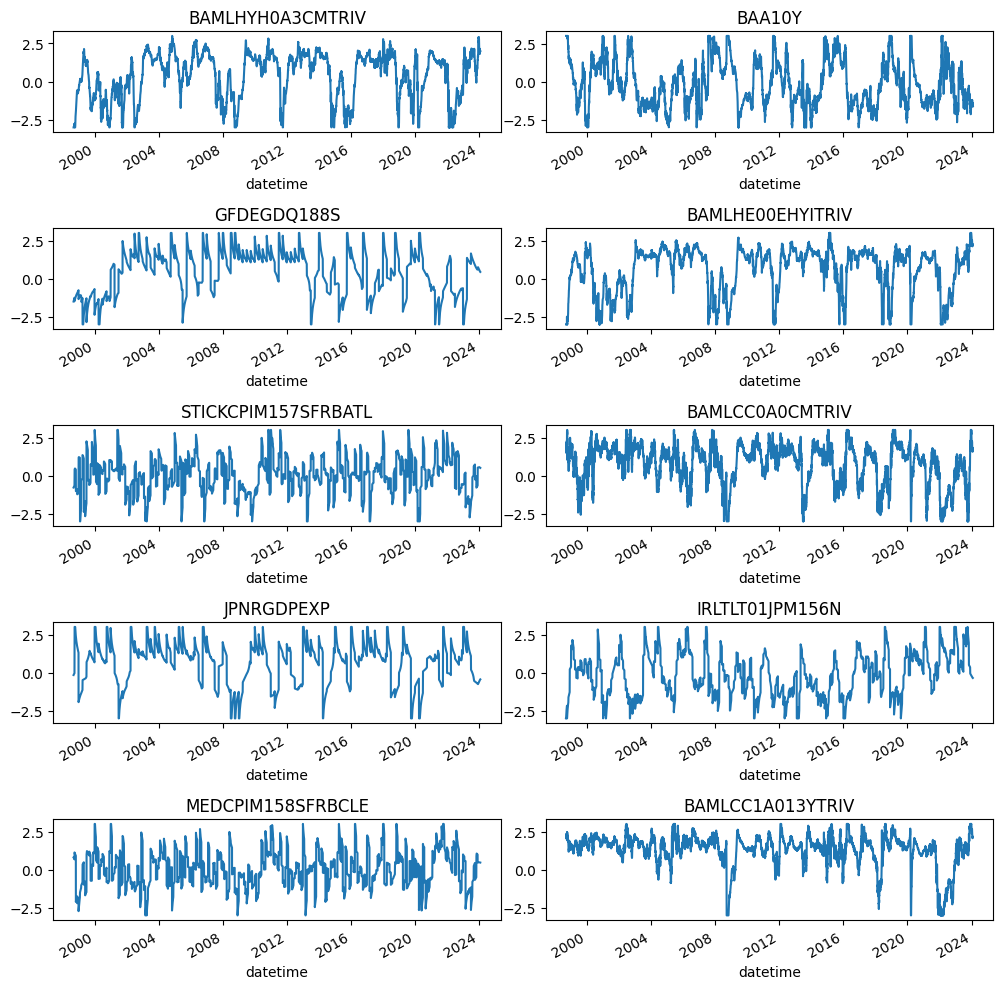

In [6]:
rolling_window = 252
zscore_indicator = zscore(indicator[random_indicators],rolling_window).clip(-3,3).dropna()
fig,axes = plt.subplots(nrows = 5, ncols = 2,figsize = (10,10))
rows = 5
cols = 2

for i,ax in enumerate(axes.flatten()):
    ts = random_indicators[i]
    zscore_indicator[ts].dropna().plot(ax = ax)
    ax.set_title(ts)

fig.tight_layout()
fig.savefig('plots/macro_indicators_after_zscore.png')

our target feature will be based on the FX spot exhange rate

More precisely, our target feature will be the cumulative return that the USD/JPY pair will yield from a period of -5 businness days before the FOMC event up to 5 days after the FOMC event, including the FOMC event daye

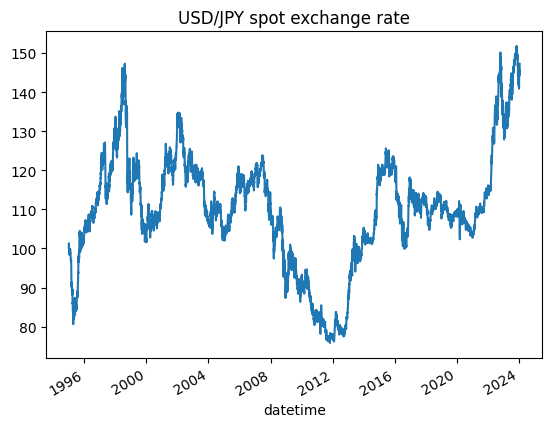

In [7]:
Y.dropna().plot(legend = False)
plt.legend = False
plt.title('USD/JPY spot exchange rate')
plt.savefig('plots/USD_JPY_spot_rate.png')

### Computing target feature : cumulative return of USD/JPY for the window -5 / + 5 businness days around the event FOMC

In [8]:
fed_meetings = get_fomc_calendar()
Y_fomc = create_Y(Y,fed_meetings,"all")
business_days = pd.date_range(start=Y_fomc.index.min(), end=Y_fomc.index.max(), freq='B')
reindexed_Y_fomc = Y_fomc.reindex(business_days)
reindexed_Y_fomc.dropna()

,Y
1995-01-24,-0.265899
1995-03-21,-3.415655
1995-05-16,-4.298536
1995-06-28,2.026001
1995-08-15,0.998137
...,...
2023-06-06,1.307989
2023-07-18,3.223852
2023-09-12,1.345410
2023-10-24,0.322313


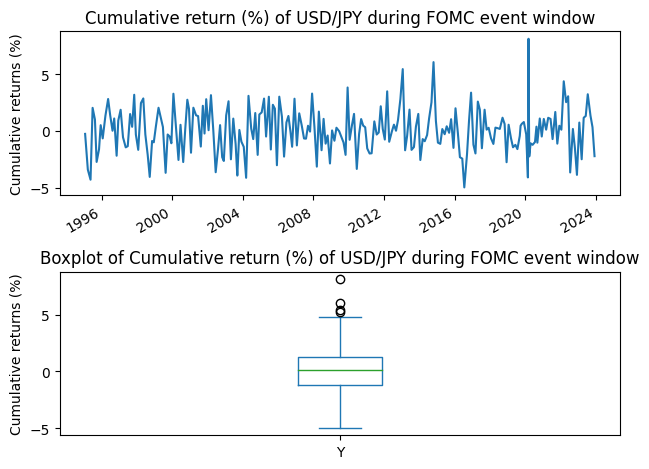

In [9]:
fig,axes = plt.subplots(nrows = 2,ncols = 1)
Y_fomc.ffill(limit = 10).plot(ax = axes[0], legend=False)
axes[0].set_title('Cumulative return (%) of USD/JPY during FOMC event window')
axes[0].set_ylabel('Cumulative returns (%)')
Y_fomc.plot(kind = 'box',ax = axes[1], legend=False)
axes[1].set_title('Boxplot of Cumulative return (%) of USD/JPY during FOMC event window')
axes[1].set_ylabel('Cumulative returns (%)')
fig.tight_layout()
fig.savefig('plots/USD_JPY_spot_rate_during_fomc.png')

We can see how this will be an "event" strategy, as we are trying to predict discontinued time series of cumulative return. Hence our trading signal will only take positions during this period of time

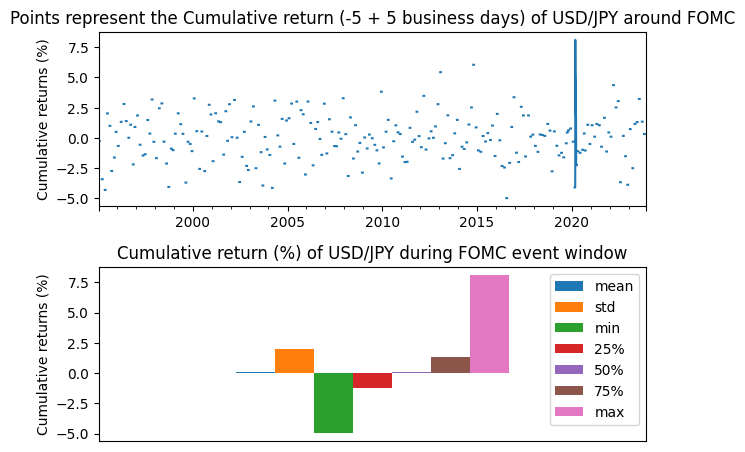

In [10]:
fig,axes = plt.subplots(nrows =2,ncols =1)
reindexed_Y_fomc.ffill(limit=10).plot(ax =axes[0],legend = False)
axes[0].set_title('Points represent the Cumulative return (-5 + 5 business days) of USD/JPY around FOMC')
axes[0].set_ylabel('Cumulative returns (%)')

Y_fomc.describe().T.drop('count',axis=1).reset_index(drop=True).plot(ax = axes[1],kind = 'bar')
axes[1].set_title('Cumulative return (%) of USD/JPY during FOMC event window')
fig.tight_layout()
axes[1].set_ylabel('Cumulative returns (%)')
axes[1].set_xticks([])

fig.savefig('plots/USD_JPY_spot_rate_during_fomc_2.png')

We can see on the above graph points represent the target feature, they are associated to the index 5 days before the FOCM event date. The continuous line in 2020 means that either we have an error in our FOMC dates scrapping, or that there were two FOMC meetings really close to each other, therefore the two periods of 10 business days overlaps

## comparing returns during FOMC period to returns during any other 10 days period


Here we look at our target data and compare it to any other 10 days period cumulative returns to see if the distribution is different, it might be shifted, skewed comapred to returns on any random dates that is not an FOMC event window

In [11]:
normal_returns = Y.dropna().pct_change().rolling(11).sum().dropna().sample(Y_fomc.shape[0]) *100
normal_returns.columns = ['Normal Returns']
fomc_returns = Y_fomc.copy().rename(columns ={'Y':'FOMC Returns'})

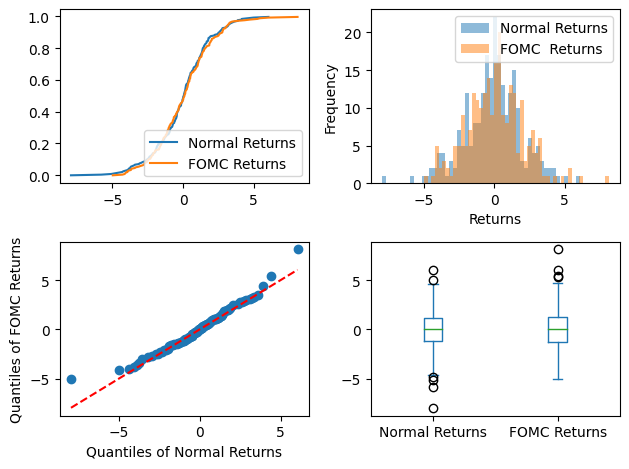

In [12]:
import numpy as np
import scipy.stats as stats

fig,axes = plt.subplots(nrows=2,ncols = 2)
normal_sorted = np.sort(normal_returns.iloc[:, 0])
fomc_sorted = np.sort(fomc_returns.iloc[:, 0])
normal_cdf = np.arange(len(normal_sorted)) / len(normal_sorted)
fomc_cdf = np.arange(len(fomc_sorted)) / len(fomc_sorted)
axes[0,0].plot(normal_sorted, normal_cdf, label='Normal Returns')
axes[0,0].plot(fomc_sorted, fomc_cdf, label='FOMC Returns')
axes[0, 0].legend()



axes[0,1].hist(normal_returns, bins=50, alpha=0.5, label = 'Normal Returns')
axes[0,1].hist(fomc_returns, bins=50, alpha=0.5, label = 'FOMC  Returns')
axes[0,1].set_xlabel('Returns')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Calculate quantiles
normal_quantiles = np.percentile(normal_returns.iloc[:, 0], np.arange(0, 101))
fomc_quantiles = np.percentile(fomc_returns.iloc[:, 0], np.arange(0, 101))

# Plotting the Q-Q plot on the specified axes
axes[1, 0].plot(normal_quantiles, fomc_quantiles, marker='o', linestyle='')
axes[1, 0].plot(normal_quantiles, normal_quantiles, 'r--')  # Line for reference
axes[1, 0].set_xlabel('Quantiles of Normal Returns')
axes[1, 0].set_ylabel('Quantiles of FOMC Returns')

combined_data = pd.concat([normal_returns, fomc_returns])
combined_data.plot(kind = 'box', ax = axes[1,1]) 
fig.tight_layout()
fig.savefig('plots/USD_JPY_spot_rate_fomc_vs_normal.png')

## Simple OLS as a benchmark


here we just do an OLS to regress our target features for the USD/JPY pair against the set of estimators we use (macroeconomic data for both US and Japan)
We use coherent data, e.g the regressors are data that would have been available in time to predict the target returns

For instance if the FOMC event window starts 02/02/2024, so that means the FOMC meets on Friday 09/02/2024, we only use available at 01/02/2024 data to predict the cumulative return from 02/02/2024 to 16/02/2024 

In [13]:
path_target_period = os.path.join("results_tuned","JPY","all")
X_train = import_data(path_target_period,"X_train")
X_val = import_data(path_target_period,"X_val")
X_test = import_data(path_target_period,"X_test")
Y_train = import_data(path_target_period,"Y_train")
Y_val = import_data(path_target_period,"Y_val")
Y_test = import_data(path_target_period,"Y_test")
Y_raw  = import_data(path_target_period,"returns")

In [14]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train) 
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

coefs = pd.DataFrame({
    'coef': model.params,
    'pvalue': model.pvalues
})

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1.401
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.128
Time:                        15:05:54   Log-Likelihood:                -163.40
No. Observations:                  92   AIC:                             400.8
Df Residuals:                      55   BIC:                             494.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4258 

Visualizing the top 10 coefficients in terms of p-value for this simple OLS benchmark

C:\Users\marti\AppData\Local\Temp\ipykernel_46276\3304352155.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_10_coefs.index, rotation=90)
C:\Users\marti\AppData\Local\Temp\ipykernel_46276\3304352155.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(top_10_coefs.index, rotation=90)


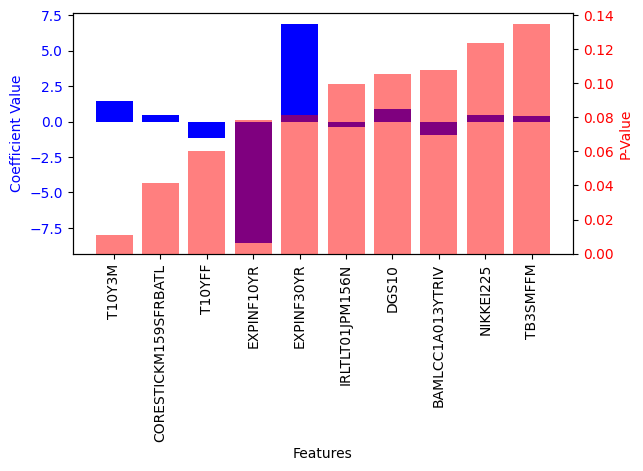

In [15]:

top_10_coefs = coefs.sort_values(by='pvalue').head(10)
# Creating the histogram plot
fig, ax1 = plt.subplots()
# Left axis for coefficients
ax1.bar(top_10_coefs.index, top_10_coefs['coef'], color='b', label='Coefficient')
ax1.set_xlabel('Features')
ax1.set_ylabel('Coefficient Value', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(top_10_coefs.index, rotation=90)
# Right axis for p-values
ax2 = ax1.twinx()
ax2.bar(top_10_coefs.index, top_10_coefs['pvalue'], color='r', alpha=0.5, label='P-Value')
ax2.set_ylabel('P-Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xticklabels(top_10_coefs.index, rotation=90)
fig.tight_layout()
fig.savefig('plots/USD_JPY_coefs_ols.png')

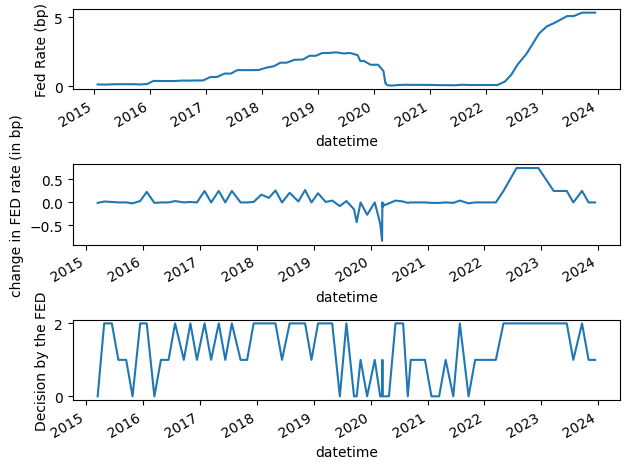

In [16]:

indicator = aggregate_data("Indicator/US").loc['2015':]
rates_change = indicator[['DFF']].shift(-1).join(fomc_calendar[['unscheduled']])

rates_change.dropna(inplace=True)
rates_change['change in fed rate'] = rates_change['DFF'].diff()
rates_change['outcome'] = np.sign(rates_change['change in fed rate']) +1

fig,axes = plt.subplots(nrows=3,ncols = 1)
rates_change['DFF'].plot(ax = axes[0])
axes[0].set_ylabel('Fed Rate (bp)')

rates_change['change in fed rate'].plot(ax = axes[1])
axes[1].set_ylabel('change in FED rate (in bp)')

rates_change['outcome'].plot(ax = axes[2])
axes[2].set_ylabel("Decision by the FED")
fig.tight_layout()
fig.savefig('plots/FOMC_change_plot.png')
fomc_calendar = pd.read_parquet('data/FOMC/fomc_calendar.parquet').set_index('datetime')
fomc_dates = rates_change['outcome'].dropna().to_dict()



2 means a hike, 0 a cut and 1 no change

visualizing profile of returns of FX spot exhange dates around FOMC event, depending on the FED's decision

here we aggregate all fomc event by their outcome, and compute the typical returns around this event by aggregating all returns of the currency pair relative to their position (in days) to the event

100%|██████████| 78/78 [00:00<00:00, 497.42it/s]


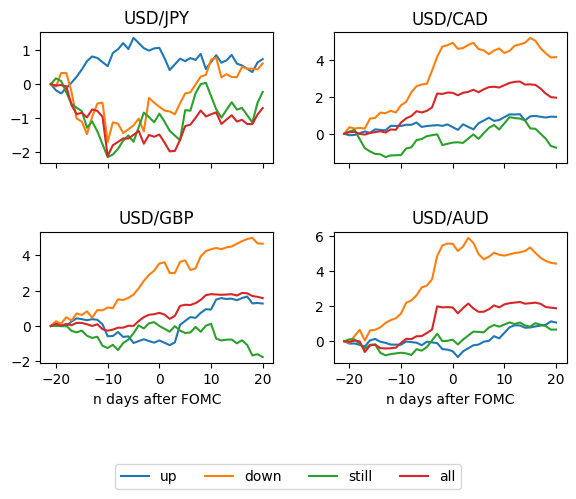

In [17]:

currencies = aggregate_data("Currencies")
list_currencies = ['JPY','CAD','GBP','AUD']
fig,axes = plt.subplots(nrows = 2, ncols = 2,sharex=True)
for i, ax in enumerate(axes.flatten()):
    curr = list_currencies[i]
    data = currencies[[curr]]
    data.columns = ['close']
    data = features_for_profile(data).fillna(0)
    profile = get_profile(data[['norm_daily_returns']],fomc_dates,offset=20) 
    (profile).cumsum().plot(ax = ax,legend=False)
    ax.set_title('USD/'+curr )
    ax.set_xlabel('n days after FOMC')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=4, bbox_to_anchor=(0.5, -0.1))
fig.tight_layout(pad=3.0)
fig.savefig('plots/profile_fomc_event.png', bbox_inches='tight')

## Visualizing Model results


now we analyze the bayesian regression model results descript in the pdf report

In [18]:
metrics = get_metrics("results_tuned","all","JPY")
coefs = get_coefs("results_tuned","all","JPY")
coefs

,T10Y2Y,BAA10Y,T10YFF,TB3SMFFM,BAAFF,MORTGAGE30US,DFF,UNRATE,CPIAUCSL,WM2NS,...,EXPINF30YR,JPNRGDPEXP,NIKKEI225,IRLTLT01JPM156N,a,b,A,B,s,R_y
0,-0.019702,-0.058434,0.030392,0.000000,-0.009097,0.000000,0.048634,-0.036045,-0.003855,-0.011409,...,0.000000,0.016599,0.039220,-0.002524,1.0,1.0,1.0,1.0,20.0,0.75
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.095850,0.000000,1.0,1.0,1.0,1.0,10.0,0.25
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057297,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,10.0,0.50
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.265641,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,10.0,0.75
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,20.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.010190,0.038475,0.006021,-0.043225,-0.002925,0.073828,0.073033,-0.074040,0.015965,0.070331,...,0.011235,-0.008272,-0.004090,0.019329,3.0,3.0,3.0,3.0,20.0,0.50
725,0.000000,0.000000,0.000000,0.000000,0.010785,-0.011641,-0.007080,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008004,0.000000,3.0,3.0,3.0,3.0,20.0,0.75
726,-0.023732,0.017183,-0.013667,-0.048693,0.026737,-0.003367,0.061972,-0.120545,0.024879,-0.001609,...,-0.029515,-0.068762,-0.008705,0.027208,3.0,3.0,3.0,3.0,30.0,0.25
727,0.009770,0.000000,0.209969,0.029473,-0.017641,-0.073019,0.120052,-0.122650,0.000000,-0.008934,...,0.067287,-0.067619,0.087448,-0.155061,3.0,3.0,3.0,3.0,30.0,0.50


In [19]:
metrics

,a,b,A,B,R_y,s,mae_test,mse_test,R2_test,SR_test,mae_val,mse_val,R2_val,SR_val,mae_train,mse_train,R2_train,SR_train
0,3,2,1,3,0.50,30,1.518092,4.447076,0.001240,0.619433,1.446774,4.147615,-0.009938,0.505204,1.638237,3.968812,-0.013453,0.001802
0,3,2,3,1,0.50,30,1.540985,4.429278,0.005237,0.565062,1.454171,4.136838,-0.007313,0.808262,1.619332,3.933808,-0.004514,-0.191955
0,3,2,2,1,0.75,30,1.545769,4.437142,0.003471,0.309223,1.460425,4.119607,-0.003118,0.487004,1.607987,3.885375,0.007853,0.487628
0,1,3,2,1,0.75,20,1.483962,3.927558,0.117917,0.470658,1.404562,3.680957,0.103693,0.598978,1.678933,4.180256,-0.067446,-0.114733
0,3,3,3,3,0.50,10,1.532695,4.327381,0.028122,0.537185,1.450996,4.052905,0.013124,0.188982,1.639182,3.986701,-0.018021,-0.062451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,1,3,1,0.75,20,1.913963,6.410742,-0.439776,-0.867144,1.802311,5.976992,-0.455388,-1.380304,1.547240,3.571011,0.088127,0.703608
0,3,3,2,2,0.25,30,1.578287,4.813524,-0.081060,-0.376303,1.512095,4.495945,-0.094755,-0.031650,1.606334,3.868394,0.012190,0.314259
0,3,1,3,2,0.25,30,1.719538,5.600407,-0.257784,-0.502704,1.647355,5.139502,-0.251461,-0.687001,1.570354,3.840769,0.019244,0.511398
0,2,3,3,3,0.25,30,1.743037,5.391921,-0.210961,-0.895909,1.630146,4.936572,-0.202047,-1.021839,1.596687,3.892219,0.006106,0.225177


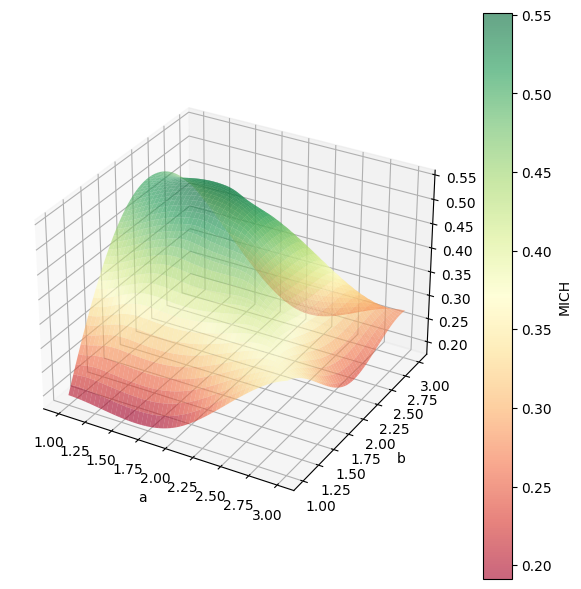

In [20]:
plot_surface_coef(coefs,param1 = "a", param2 = 'b',coef_name = "MICH")

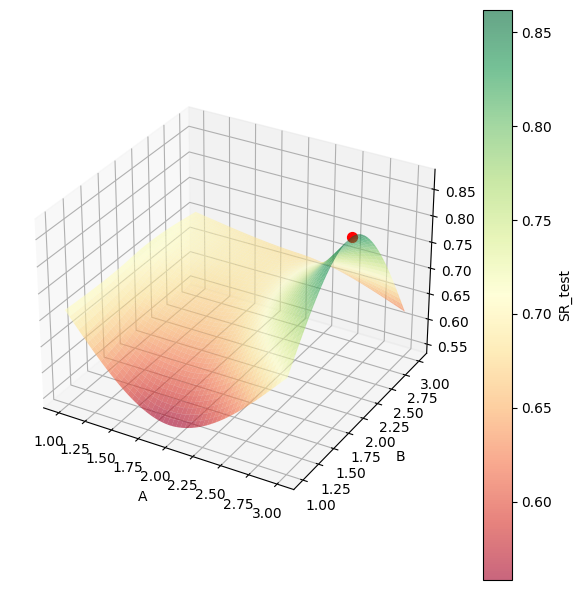

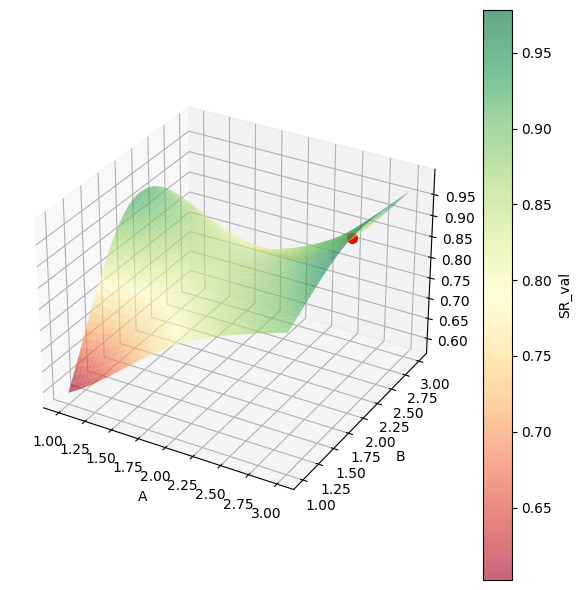

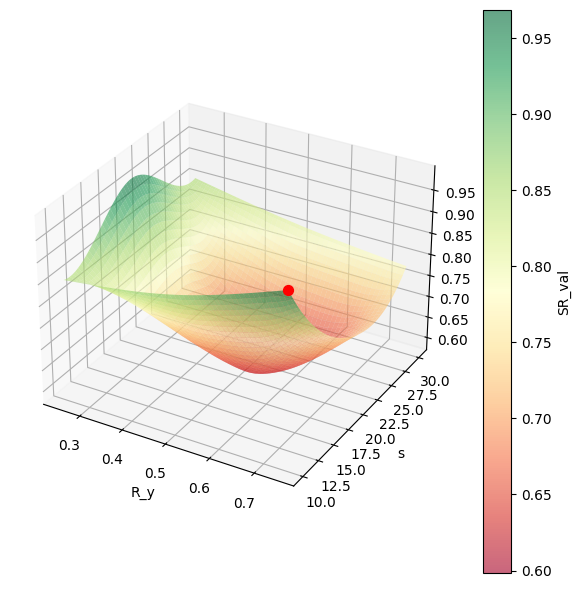

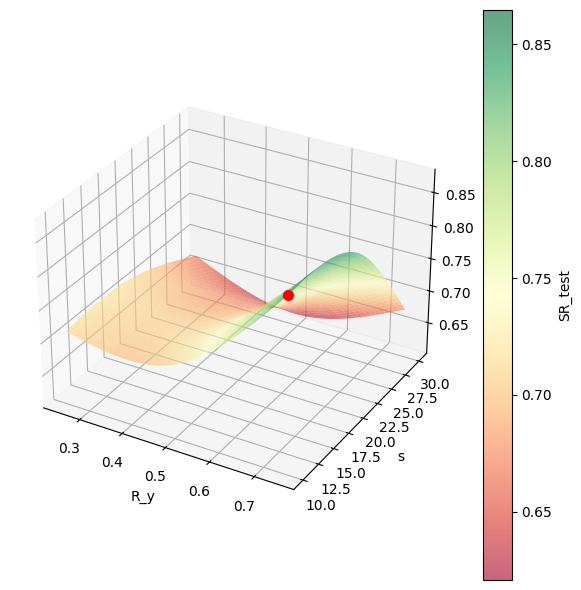

In [21]:
plot_surface_metric(metrics,"A","B","SR_test")
plot_surface_metric(metrics,"A","B","SR_val")

plot_surface_metric(metrics,"R_y","s","SR_val")
plot_surface_metric(metrics,"R_y","s","SR_test")



In [22]:
metrics = get_metrics("results_tuned","all","JPY")
coefs = get_coefs("results_tuned","all","JPY")
path_target_period = os.path.join("results_tuned","JPY","all")
X_train = import_data(path_target_period,"X_train")
X_val = import_data(path_target_period,"X_val")
X_test = import_data(path_target_period,"X_test")
Y_train = import_data(path_target_period,"Y_train")
Y_val = import_data(path_target_period,"Y_val")
Y_test = import_data(path_target_period,"Y_test")
Y_raw  = import_data(path_target_period,"returns")

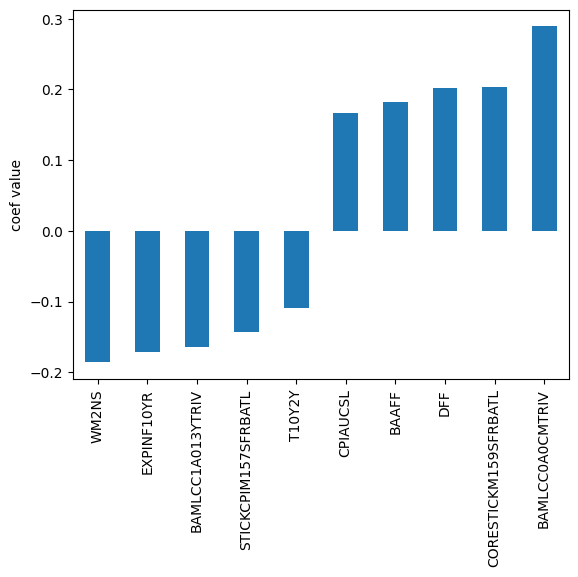

In [23]:
results= metrics.copy()
results = results.sort_values(by= "SR_train",ascending= False)
a,b,A,B,s,R_y = (*get_best_parameters(results),)
betas = recover_model(coefs,a,b,A,B,s,R_y)
predictions= (get_prediction(X_test,betas,X_test.index))
fig,axes = plt.subplots(nrows=1,ncols =1)
bottom_betas = betas.sort_values(by = 'coef',ascending=True).head(5) 
top_betas= betas.sort_values(by = 'coef',ascending=False).head(5)
concatenated_betas = pd.concat([top_betas, bottom_betas]).sort_values(by='coef')
concatenated_betas.sort_values(by = 'coef').plot(kind = 'bar', ax = axes,legend=False)
axes.set_ylabel('coef value')

fig.savefig('plots/bayes_coefs_jpy.png')

In [24]:
coefs_to_plot= ["DFF","MICH","UNRATE","STICKCPIM157SFRBATL"]
coefs_comparison = pd.DataFrame(index = CURRENCIES, columns = ["DFF","MICH","UNRATE","STICKCPIM157SFRBATL"])
for currency in tqdm(CURRENCIES):
    metrics = get_metrics("results_tuned","all",currency)
    coefs = get_coefs("results_tuned","all",currency)
    results = metrics.sort_values(by= "R2_train",ascending= False)
    a,b,A,B,s,R_y = (*get_best_parameters(metrics),)
    s = 30
    R_y = 0.75
    betas = coefs.query('a == @a and b == @b and A == @A and B == @B and s == @s and R_y == @R_y').drop(["a","b","A","B","s","R_y"],axis=1).T
    betas = recover_model(coefs,a,b,A,B,s,R_y)
    for ts in coefs_to_plot:
        coefs_comparison.loc[currency,ts] =  betas.loc[ts,'coef']


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


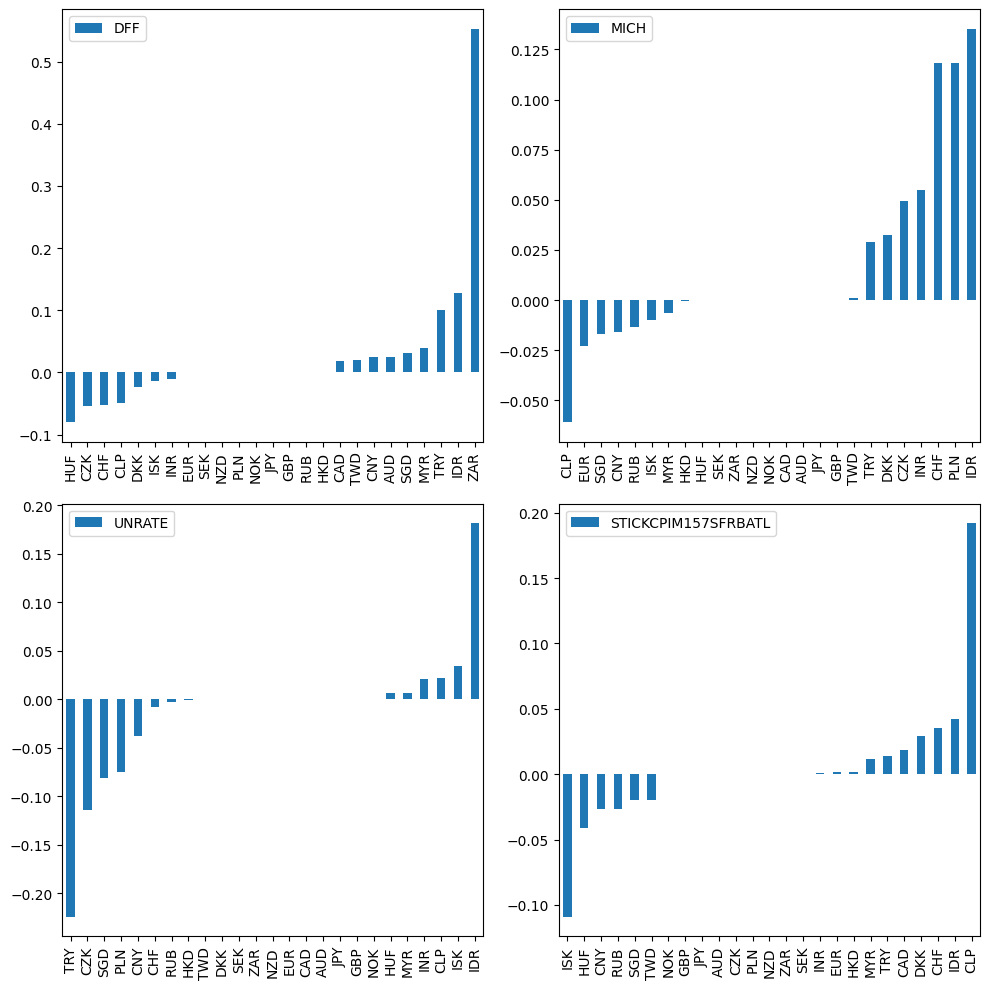

In [25]:
fig,axes = plt.subplots(nrows = 2,ncols = 2,sharex=False, figsize = (10,10))
for i,ax in enumerate(axes.flatten()):
    coefs_comparison.iloc[:,i].sort_values().plot(kind = 'bar',ax = ax, label = coefs_to_plot[i])
    ax.legend()
fig.tight_layout()
fig.savefig('plots/cmpr_coefs_fomc.png')

For 4 currencies, we plot the regression plot obtained by the best model on the R2 of the val set, as well as confusion matrix
Confusion matrix are obtained after comparing the sign of our predictions and the sign of the true cumulative return we try to predict


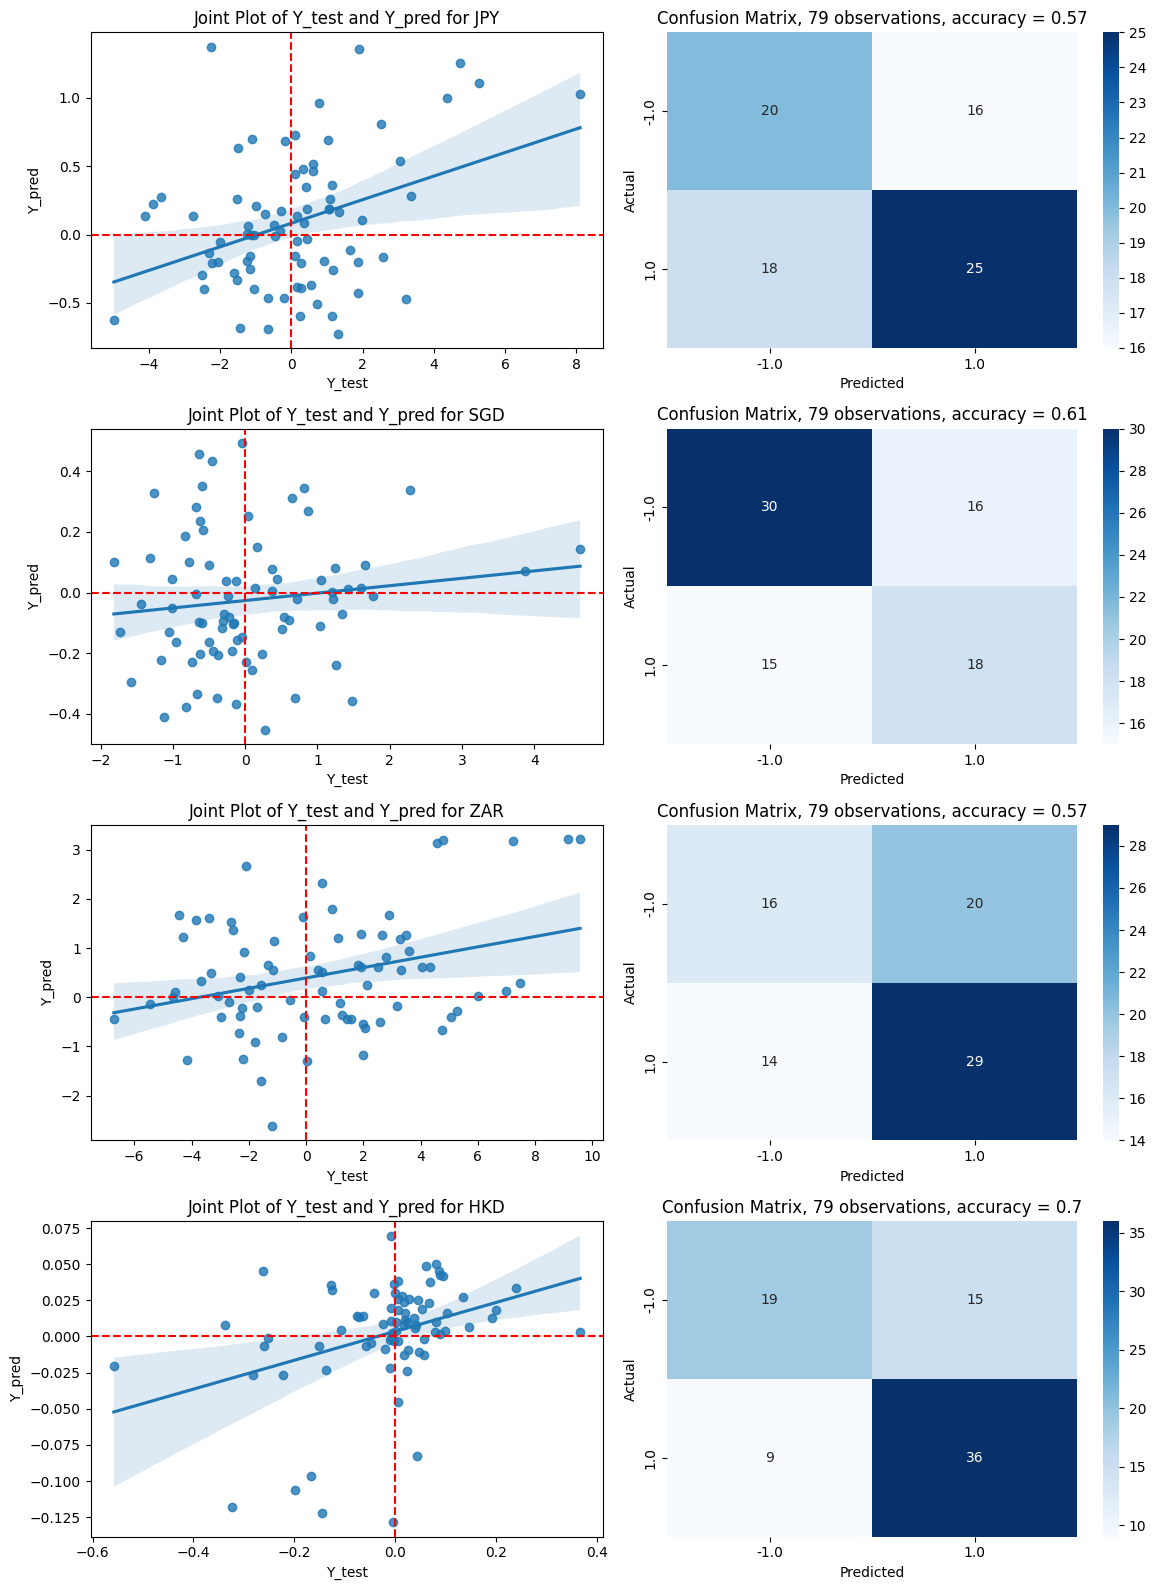

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [26]:
currency_to_plot = ["JPY", "SGD", "ZAR", "HKD"]

fig, axes = plt.subplots(nrows=len(currency_to_plot), ncols=2, figsize=(12, 4 * len(currency_to_plot)))

for i, currency in enumerate(currency_to_plot):
    path_target_period = os.path.join("results_tuned", currency, "all")
    # Assuming the import_data function and other functions work as intended
    X_train = import_data(path_target_period, "X_train")
    X_val = import_data(path_target_period, "X_val")
    X_test = import_data(path_target_period, "X_test")
    Y_train = import_data(path_target_period, "Y_train")
    Y_val = import_data(path_target_period, "Y_val")
    Y_test = import_data(path_target_period, "Y_test")
    Y_raw = import_data(path_target_period, "returns")

    metrics = get_metrics("results_tuned", "all", currency)
    coefs = get_coefs("results_tuned", "all", currency)

    ## sorting combinaison based on the R2 they yielded on the val set
    metrics = metrics.sort_values(by="R2_val", ascending=False)
    a, b, A, B, s, R_y = (*get_best_parameters(metrics),)
    betas = recover_model(coefs, a, b, A, B, s, R_y)
    predictions = get_prediction(X_test, betas, X_test.index)
    cmpr = pd.DataFrame({'Y': Y_test.iloc[:, 0], 'predictions': predictions.iloc[:, 0]})
    sns.regplot(x='Y', y='predictions', data=cmpr, ax=axes[i, 0])
    axes[i, 0].set_xlabel('Y_test')
    axes[i, 0].set_ylabel('Y_pred')
    axes[i, 0].axvline(0, color='r', ls='--')
    axes[i, 0].axhline(0, color='r', ls='--')
    axes[i, 0].set_title(f'Joint Plot of Y_test and Y_pred for {currency}')

    cmpr = np.sign(cmpr)
    accuracy = accuracy_score(cmpr['Y'], cmpr['predictions'])
    cm = confusion_matrix(cmpr['Y'], cmpr['predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["-1.0", "1.0"], yticklabels=["-1.0", "1.0"],ax = axes[i,1])
    axes[i,1].set_ylabel('Actual')
    axes[i,1].set_xlabel('Predicted')
    axes[i,1].set_title('Confusion Matrix, {} observations, accuracy = {}'.format(cmpr.shape[0], np.round(accuracy,2)))

fig.tight_layout()
fig.savefig('plots/regplot_and_confusion_matrix.png')

### Aggregating model results to create a global long short portfolio

here we look for each currency the simulation that yielded the best results in terms of sharpe ratio on the validation set
we recover the hyperparameters a,b,A,B,s and R_y and recover the coefficient values
We make our predictions on the test set for each currency and compute a PnL based on these raw predictions
Raw predictions will serve as the first basis for our L/S weights, after several transformations (see next section)

In [27]:
pnls = {}
signals ={}
returns = {}
table_results = pd.DataFrame(index =CURRENCIES, columns = ['beta','T-stat','R2','p-value','bias (bp)', '% winning trade','Sharpe ratio']) 

for curr in tqdm(CURRENCIES):
    pnl_all,signal_all,ret  = get_best_pnl(curr,"all",criterion = "SR_val")
    signals[curr] = signal_all 
    pnls[curr] = pnl_all
    returns[curr] = ret
    cmpr = ret.pct_change().join(signal_all/100).dropna()
    beta, t_stat, p_value, r_squared = simple_ols_regression(cmpr)
    table_results.loc[curr,'beta'] = beta
    table_results.loc[curr,'T-stat'] = t_stat
    table_results.loc[curr,'R2'] = r_squared
    table_results.loc[curr,'p-value'] = p_value
    table_results.loc[curr,'bias (bp)'] = pnl_all.mean() *1e4
    table_results.loc[curr,'Sharpe ratio'] = sharpe_ratio(pnl_all)
    table_results.loc[curr,'% winning trade'] =((np.sign(pnl_all.replace(0,np.nan).dropna())+1).sum()/2)/ pnl_all.replace(0,np.nan).dropna().shape[0]

pnl_combined = pd.concat(pnls,axis=1)
alpha = pd.concat(signals,axis=1).droplevel(axis=1,level=1)

100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


In [28]:
table_results

,beta,T-stat,R2,p-value,bias (bp),% winning trade,Sharpe ratio
EUR,2.598954,1.153745,0.001617,0.24894,0.009373,0.51411,0.441668
RUB,0.127992,0.287055,0.0001,0.774143,1.088174,0.517705,0.297019
GBP,0.122201,1.459613,0.002585,0.144778,0.291747,0.510429,0.552836
CNY,0.343072,0.773892,0.000728,0.439217,0.00964,0.509804,0.551941
JPY,0.217785,2.473166,0.007386,0.013593,0.432168,0.529197,0.864509
SGD,0.058536,1.489187,0.002691,0.136822,0.168231,0.527027,0.435766
INR,1.787566,1.336242,0.002167,0.18184,0.005143,0.517748,0.464465
CHF,0.696985,2.528048,0.007715,0.011656,0.107118,0.554321,0.741863
AUD,0.409369,1.742541,0.00368,0.081788,0.185652,0.522755,0.638898
CAD,0.041475,0.722026,0.000634,0.470484,0.270281,0.506716,0.454386


In [29]:
print(table_results.to_latex())

\begin{tabular}{llllllll}
\toprule
 & beta & T-stat & R2 & p-value & bias (bp) & % winning trade & Sharpe ratio \\
\midrule
EUR & 2.598954 & 1.153745 & 0.001617 & 0.248940 & 0.009373 & 0.514110 & 0.441668 \\
RUB & 0.127992 & 0.287055 & 0.000100 & 0.774143 & 1.088174 & 0.517705 & 0.297019 \\
GBP & 0.122201 & 1.459613 & 0.002585 & 0.144778 & 0.291747 & 0.510429 & 0.552836 \\
CNY & 0.343072 & 0.773892 & 0.000728 & 0.439217 & 0.009640 & 0.509804 & 0.551941 \\
JPY & 0.217785 & 2.473166 & 0.007386 & 0.013593 & 0.432168 & 0.529197 & 0.864509 \\
SGD & 0.058536 & 1.489187 & 0.002691 & 0.136822 & 0.168231 & 0.527027 & 0.435766 \\
INR & 1.787566 & 1.336242 & 0.002167 & 0.181840 & 0.005143 & 0.517748 & 0.464465 \\
CHF & 0.696985 & 2.528048 & 0.007715 & 0.011656 & 0.107118 & 0.554321 & 0.741863 \\
AUD & 0.409369 & 1.742541 & 0.003680 & 0.081788 & 0.185652 & 0.522755 & 0.638898 \\
CAD & 0.041475 & 0.722026 & 0.000634 & 0.470484 & 0.270281 & 0.506716 & 0.454386 \\
HKD & 0.112886 & 2.210252 & 0.005908

Building cross sectionnal weights and computing total PnL

Sharpe Ratio    2.6
Bias (bp)       2.5
Turnover (%)    6.4
dtype: float64

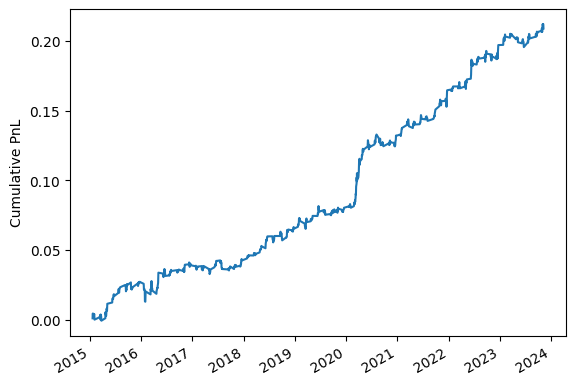

In [30]:
## agregatting signals together
signals_aggregated = pd.concat(signals,axis=1).droplevel(axis=1,level=1)

## rank cross sectionnaly and apply gaussian distribution
signals_aggregated = signals_aggregated.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

## center signal to ensure zero sum of weights
signals_aggregated = signals_aggregated.sub(signals_aggregated.mean(1),0)

## normalize the signal to have a constant sum of absolute weights to 1
alpha = signals_aggregated.div(signals_aggregated.abs().sum(1),0)

## concat true returns
R = pd.concat(returns,axis=1).droplevel(axis=1,level=1).pct_change()

## pnl = alpha * returns, alpha shifted of one day just in case they were a data look ahead, but I don't think so
pnls = (alpha.shift() * R).dropna(axis=0,how = 'all')
## daily pnl is the sum of pnl made on each currency
pnl = pnls.sum(1) 

turnover = alpha.fillna(0).diff().abs().sum(1).mean() *100

pnl.cumsum().plot()
plt.ylabel('Cumulative PnL')
plt.savefig('plots/cumulative_pnl.png')
pd.Series({"Sharpe Ratio":sharpe_ratio(pnl),'Bias (bp)':pnl.mean()*1e4, 'Turnover (%)':turnover}).round(1)

if we don't shift our alpha by one day, as there is normally no data look ahead bias, e.g. the signal on day t use data only available before the Open at date T



Sharpe Ratio    2.9
Bias (bp)       2.8
Turnover (%)    6.4
dtype: float64

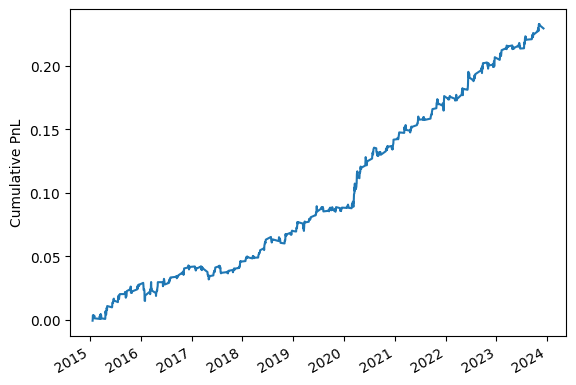

In [31]:
## agregatting signals together
signals_aggregated = pd.concat(signals,axis=1).droplevel(axis=1,level=1)

## rank cross sectionnaly and apply gaussian distribution
signals_aggregated = signals_aggregated.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

## center signal to ensure zero sum of weights
signals_aggregated = signals_aggregated.sub(signals_aggregated.mean(1),0)

## normalize the signal to have a constant sum of absolute weights to 1
alpha = signals_aggregated.div(signals_aggregated.abs().sum(1),0)

## concat true returns
R = pd.concat(returns,axis=1).droplevel(axis=1,level=1).pct_change()
pnls = (alpha * R).dropna(axis=0,how = 'all')
## daily pnl is the sum of pnl made on each currency
pnl = pnls.sum(1) 
turnover = alpha.fillna(0).diff().abs().sum(1).mean() *100
pnl.cumsum().plot()
plt.ylabel('Cumulative PnL')
plt.savefig('plots/cumulative_pnl.png')
pd.Series({"Sharpe Ratio":sharpe_ratio(pnl),'Bias (bp)':pnl.mean()*1e4, 'Turnover (%)':turnover}).round(1)

visualizing how we transform raw model predictions into cross sectionnal Long Short weights 

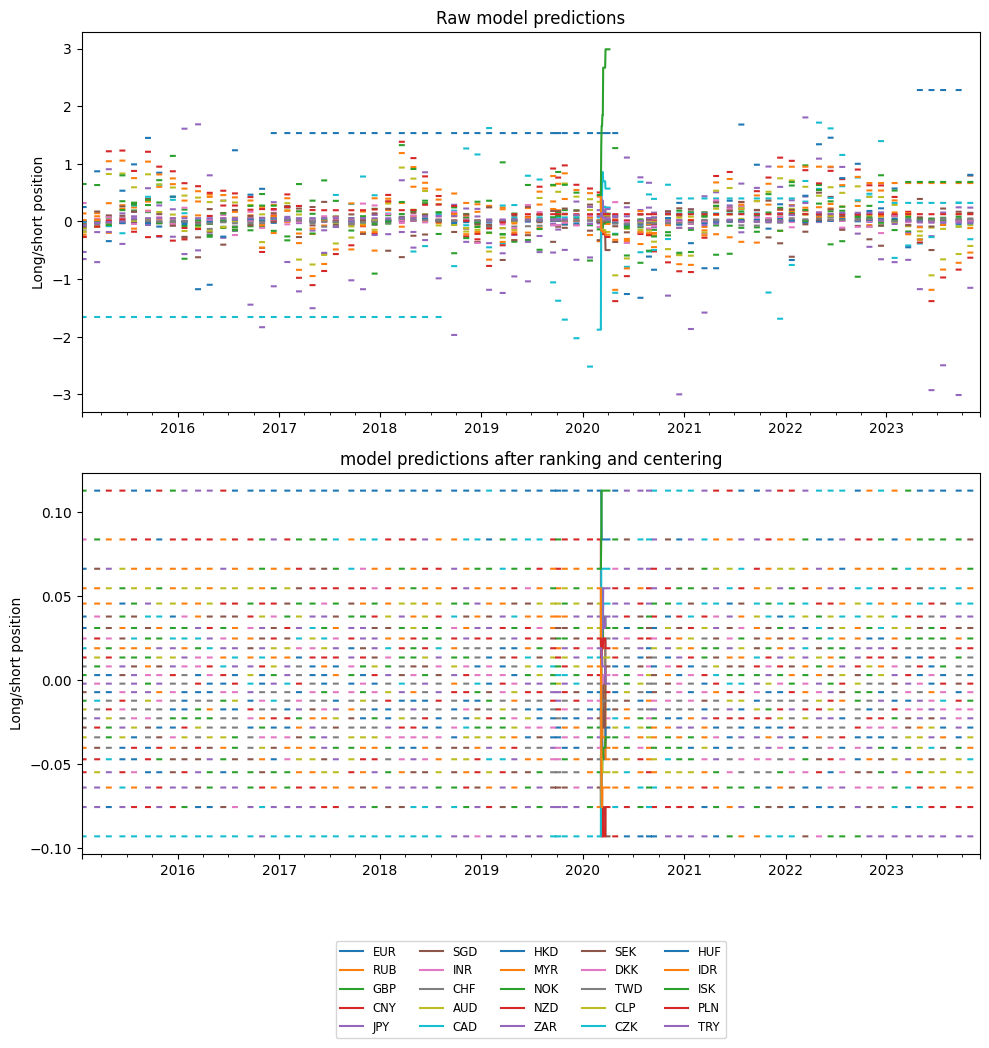

In [32]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize = (10,10))
pd.concat(signals,axis=1).droplevel(axis=1,level=1).plot(ax = axes[0],legend=False)
axes[0].set_title('Raw model predictions')
axes[0].set_ylabel('Long/short position')
alpha.plot(ax = axes[1])
axes[1].set_title('model predictions after ranking and centering')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=5,fontsize='small')
axes[1].set_ylabel('Long/short position')
fig.subplots_adjust(bottom=0.3)
fig.tight_layout()
fig.savefig('plots/model_predictions_positions.png')

We check that on days we trade, we have a a nominal of 1 $ (left plot) and zero exposure in aggregate to the dollar (right plot)

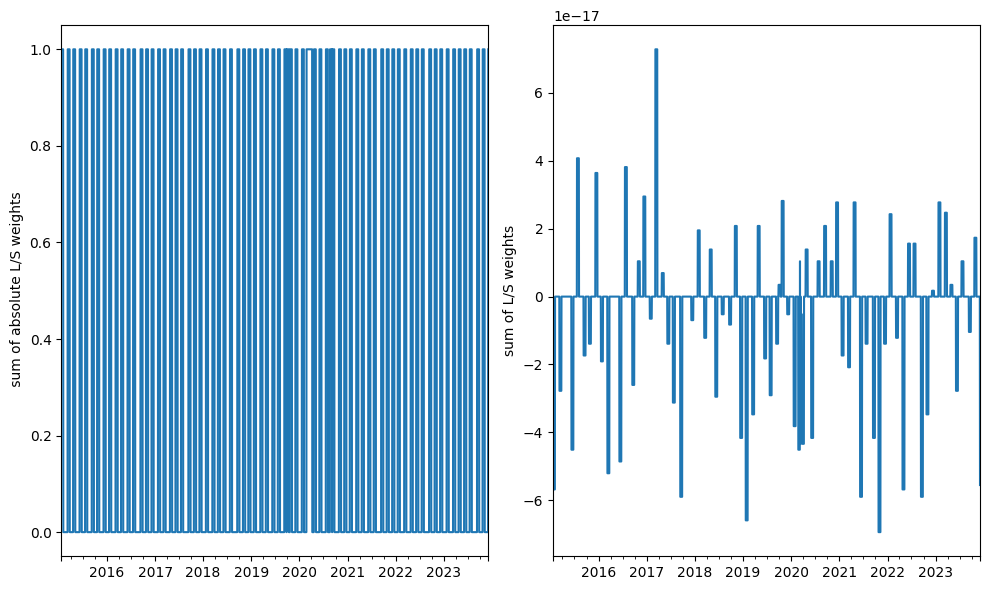

In [36]:
fig,axes = plt.subplots(nrows=1,ncols =2,figsize = (10,6))
alpha.abs().sum(1).plot(ax = axes[0])
axes[0].set_ylabel(' sum of absolute L/S weights')
alpha.sum(1).plot(ax = axes[1])
axes[1].set_ylabel('sum of L/S weights')
fig.tight_layout()
fig.savefig('plots/sum_weights.png')

Looking at how each currency contributes to the global PnL and how is the correlation between each asset we trade

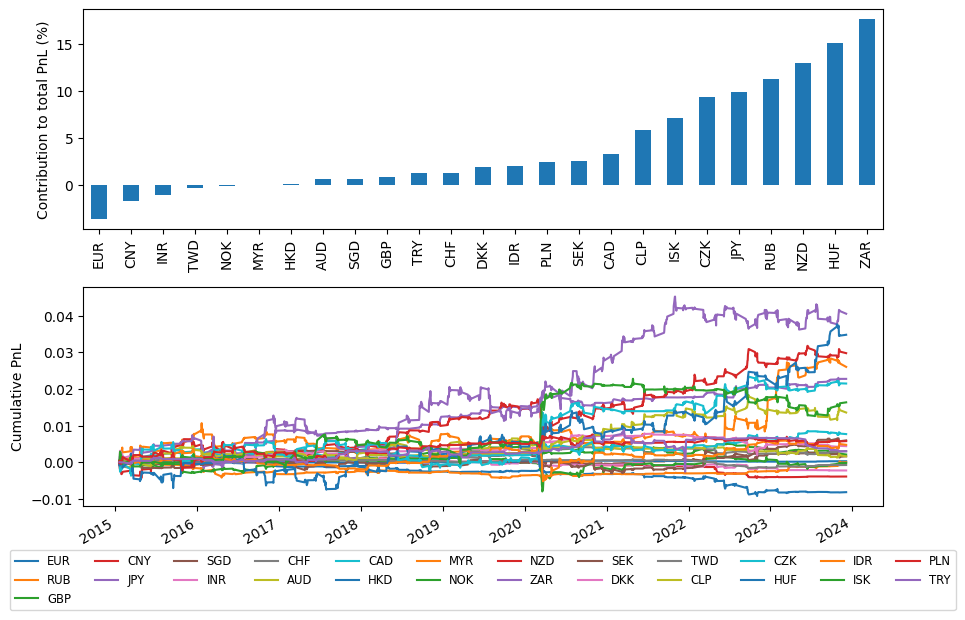

In [34]:
fig,axes = plt.subplots(ncols=1,nrows =2,figsize = (10,6))
(100*(pnls.cumsum().iloc[-1] / pnl.cumsum().iloc[-1]).sort_values()).plot(ax = axes[0],kind ='bar')
axes[0].set_ylabel('Contribution to total PnL (%)')
pnls.cumsum().plot(ax = axes[1])
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=12,fontsize='small')
axes[1].set_ylabel('Cumulative PnL')
fig.subplots_adjust(bottom=0.3)
fig.tight_layout()
fig.savefig('plots/contribution_pnl.png')


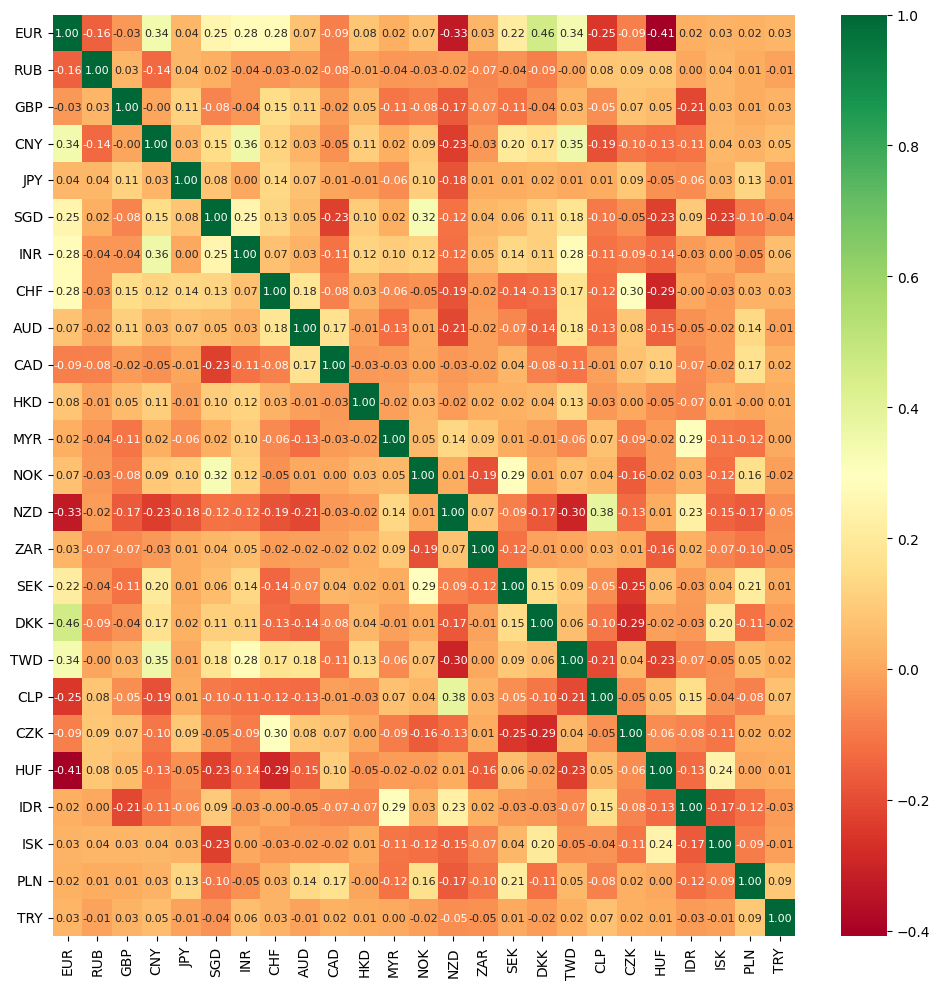

In [35]:
daily_cov_matrix = pnls.corr()
annual_cov_matrix = daily_cov_matrix
fig,axes = plt.subplots(nrows=1,ncols=1, figsize = (10,10))
sns.heatmap(annual_cov_matrix, annot=True, fmt='.2f', cmap='RdYlGn',ax = axes,annot_kws={"size": 8})
fig.tight_layout()
fig.savefig('plots/pnl_corr_matrix.png')